In [1]:
import copy

import numpy as np

import scipy.integrate as integrate
from scipy import constants
from scipy import interpolate

# Plotting
import matplotlib.pyplot as plt
from matplotlib import scale as mscale
from matplotlib.transforms import Transform
from matplotlib.ticker import FixedLocator

import seaborn as sns

# CLASS

from classy import Class

In [2]:
_GN_ = constants.gravitational_constant # Meter^3 Kilogram^-1 Second^-2 
_c_light_ = constants.c # Meter Second^-1
_eV_ = constants.eV; # Meter^2 Kilogram Second^-2
_kB_ = constants.Boltzmann # Joule Kelvin^-1
_hP_ = constants.Planck # Joule Second 
_aB_ = 8*np.pi**5*_kB_**4/(15*_hP_**3*_c_light_**3) #Joule Kelvin^-4 Meter-3

#Conversions
_Meter_per_MPc_ = constants.mega*constants.parsec
H_0_std=100 * constants.kilo/_Meter_per_MPc_

#Class Default Values
Tcmb_pk = 2.7255 # Kelvin 
Nur_pk = 3.046;
h_pk = 0.67556;
omega_b_pk = 0.022032;
omega_cdm_pk = 0.12038;

Omega_b_pk = omega_b_pk/(h_pk**2)
Omega_cdm_pk = omega_cdm_pk/(h_pk**2)

H_0_pk= h_pk* H_0_std
rho_crit_pk= 3* H_0_pk**2 /(8*np.pi*_GN_)


def a_of_z(z,a_0=1.):
    return a_0/(1.+z)

In [3]:
class cosmic_fluid(object):
    """A fluid model for cosmic material
    
        naught values corrispond to today
        
        """
    def p(self,a):
        return self.rho(a) * self.w(a)
 
        
class cosmic_fluid_const_w(cosmic_fluid):
    """A cosmic fluid with constant w(a)"""
    
    def __init__(self,rho_ref,w,a_0=1.,a_ref=1.):
        self.w = lambda a=a_0: w
        self.a_0 = a_0
        self.a_ref = a_ref
        self.rho_0 = rho_ref * (a_ref/a_0)**(3*(1+w))
        
        
    def rho(self,a):
        return self.rho_0*(self.a_0/a)**(3*(1+ self.w()))
    

    
class cosmic_fluid_spline_w(cosmic_fluid):
    """A cosmic fluid with a given spline made with numpy.interpolate.splrep for w(a)"""
    
    def __init__(self,rho_ref,spline_log10a_vals,spline_w_vals,a_0=1.,a_ref=1.):
        
        #Store spline knots and create spline representation
        self.spline_log10a_vals=spline_log10a_vals
        self.spline_w_vals=spline_w_vals
        self.w_spline_rep=interpolate.splrep(spline_log10a_vals,spline_w_vals, s=0)
        
        self.w = lambda a:interpolate.splev(np.log10(a), self.w_spline_rep, der=0)
        self.a_0 = a_0
        self.a_ref= a_ref
        self.rho_0 = rho_ref * (a_ref/a_0)**3* 10**(-3*interpolate.splint(np.log10(a_ref),np.log10(a_0),self.w_spline_rep))
        
    def rho(self,a):
        return self.rho_0*(self.a_0/a)**3 * 10**(-3*interpolate.splint(np.log10(self.a_0),np.log10(a),self.w_spline_rep))
    

In [4]:
#A test of spline vs constant w

# Standard rho_0 for photos
def rho_0_gamma(T=Tcmb_pk):
    return _aB_ / _c_light_**2 * T**4

#Spline knots
log10a_vals= np.arange(-14.5,0.5,0.1)
w_vals=np.array([1/3]*len(log10a_vals))


#Constant w model
gamma= cosmic_fluid_const_w(rho_0_gamma(),1/3)
gamma_spl= cosmic_fluid_spline_w(rho_0_gamma(),log10a_vals,w_vals)

#Ensure rho,p,w have evolved correctly
tol=10**-15

w_test=10**-2

[abs(gamma.rho(w_test)-gamma_spl.rho(w_test))<tol,
 abs(gamma.p(w_test)-gamma_spl.p(w_test))<tol,
 abs(gamma.w(w_test)-gamma_spl.w(w_test))<tol]

[True, True, True]

In [5]:
class composite_fluid(object):
    """ A collection of cosmic fluids with methods to have sum total of properties"""
        
    def __init__(self,fluids,a_0=1):
        self.fluids = copy.copy(fluids)
        self.rho_0  = 0
        self.a_0    = a_0

        for fluid in fluids:
            self.rho_0  += fluid.rho_0
            assert self.a_0 == fluid.a_0,"Uncommon scale factor for today"

    #Energy Density 
    def rho_tot(self,a):
        rho_tot=0
        for fluid in self.fluids:
            rho_tot += fluid.rho(a)
        return rho_tot
    
    #Pressure 
    def p_tot(self,a):
        p_tot=0
        for fluid in self.fluids:
            p_tot += fluid.p(a)
        return p_tot
    
    #State parameter (Ineffient since p will also call rho, but probably doesn't matter)
    def w(self,a):
        return self.p_tot(a)/self.rho_tot(a) 
    
    #What fraction does a fluid contribute to the total rho
    def rho_fluid_frac(self,fluid,a):
        return fluid.rho(a)/self.rho(a)
    
    #What fraction does a fluid contribute to the total pressure
    def p_fluid_frac(self,fluid,a):
        return fluid.p(a)/self.p (a)
    

class universe(composite_fluid):
    """ A model of the univsere as a collection of cosmic fluids
  
  
                Several optional arguments
        
                    h - If provided a cosmological constant is added to satisfy H_0
                    k - Non-functioning for curvrature 
                    a_0 - a common scale factor value for today amongst the fluids
                
                To Consider:
                    Safty Checks on if fluid is in set of fluids"""
        
        
    def __init__(self,fluids,h=None,k=0,a_0=1):
        assert k==0, "non-flat conditions have not been coded"        
        self.fluids = copy.copy(fluids)
        
        self.rho_0  = 0
        self.a_0    = a_0
        for fluid in fluids:
            self.rho_0  += fluid.rho_0
            assert self.a_0 == fluid.a_0,"Uncommon scale factor for today"

        if h==None:
            self.rho_crit = self.rho_0
            self.H_0 =((8*np.pi*_GN_)*self.rho_crit/3)**0.5
            self.h = self.H_0/H_0_std
        else:
            self.h=h
            self.H_0= h * H_0_std
            self.rho_crit= 3*(h * H_0_std)**2/(8*np.pi*_GN_)
            if(self.rho_crit- self.rho_0!=0):
                self.dark_energy = cosmic_fluid_const_w(self.rho_crit- self.rho_0, -1,a_0)
                self.fluids= self.fluids+[self.dark_energy]
            
 
    
    def Omega(self,fluid):
        return fluid.rho_0/self.rho_crit
        
    def omega(self,fluid):
        return fluid.rho_0/self.rho_crit * self.h ** 2 
    

In [6]:
def rho_0_gamma_pk(T=Tcmb_pk):
    return _aB_ / _c_light_**2 * T**4

gamma= cosmic_fluid_const_w(rho_0_gamma_pk(),1/3)

def rho_0_nu_pk(T=Tcmb_pk,Nur=Nur_pk):
    return   rho_0_gamma_pk(T)  *7./8.*(4./11.)**(4./3.)*Nur

nu = cosmic_fluid_const_w(rho_0_nu_pk(),1/3)


def rho_0_b_pk(Omega_b=Omega_b_pk,rho_crit=rho_crit_pk):
    return Omega_b* rho_crit

baryons = cosmic_fluid_const_w(rho_0_b_pk(),0)

def rho_0_cdm_pk(Omega_cdm=Omega_cdm_pk,rho_crit=rho_crit_pk):
    return Omega_cdm* rho_crit

cdm = cosmic_fluid_const_w(rho_0_cdm_pk(),0)

fluids=[gamma,nu,baryons,cdm]

LCDM=universe(fluids,h_pk) 

In [7]:
rho_0_cdm_pk(Omega_cdm=Omega_cdm_pk*0.1)/(rho_0_gamma_pk()+rho_0_nu_pk()+rho_0_b_pk()+rho_0_cdm_pk())

0.08450456829531756

In [8]:
rho_0_nu_pk(Nur=Nur_pk*0.1)/(rho_0_gamma_pk()+rho_0_nu_pk()+rho_0_b_pk()+rho_0_cdm_pk())

1.200899486342582e-05

In [9]:
rho_0_cdm_pk(Omega_cdm=Omega_cdm_pk*0.1)/(rho_0_gamma_pk()+rho_0_nu_pk()+rho_0_b_pk()+rho_0_cdm_pk(Omega_cdm=Omega_cdm_pk*0.9))

0.09230474054683951

In [10]:
#Test Omega_tot=1
Omega_tot=0
for fluid in LCDM.fluids:

    Omega_tot+=LCDM.Omega(fluid)

Omega_tot==1

True

In [11]:
class classy_params:
    """A class to contain classy parameters, it stores both a numeric form for arithmetic and a copy with the format classy will take."""
    
    def to_classy_dict(self,**kwargs):
        """Converts from a dictionary of various types to ones that classy can use."""
        classy_dict={}
        for key,val in kwargs.items():
            if isinstance(val, (list, tuple, np.ndarray)):
                classy_dict[key]=(','.join([str(num) for num in val]))
            else: 
                classy_dict[key]=val
        return classy_dict
                
    
    def __init__(self,**kwargs):
        self.raw_params=kwargs
        self.classy_dict=self.to_classy_dict(**kwargs)

    def update_param(self,key,new_val):
        """Update the stored value for the key parameter in both numeric and classy form """
        self.raw_params[key]=new_val
        if isinstance(new_val, (list, tuple, np.ndarray)):
            self.classy_dict[key]=(','.join([str(num) for num in new_val]))
        else: 
            self.classy_dict[key]=new_val

In [12]:
def get_raw_cl(**classy_parm_dict):
    """ Returns a dictionary with the raw_cl values,for tt,te,ee for l values 2-2500 """
    cosmo = Class()
    cosmo.set({**{'output': 'tCl,pCl'},**classy_parm_dict})
    cosmo.compute()
    return {'tt':cosmo.raw_cl()['tt'][2:],'ee':cosmo.raw_cl()['ee'][2:],'te':cosmo.raw_cl()['te'][2:]}

def fisher_cl(**classy_parm_dict):

    raw_cl=get_raw_cl(**classy_parm_dict)
    
    wtinv=(11*10**-8)**2 # K^2 likely need to be changed, but can't find definitive source
    weinv=(25*10**-8)**2 # K^2 likely need to be changed, but can't find definitive source
    B_l_inv=np.exp((np.arange(2,2501)*0.16*np.pi/180)**2)  #likely need to be changed, but can't find definitive source
    err_t_l=wtinv*B_l_inv;
    err_e_l=weinv*B_l_inv;
    fsky=0.8;
    cov_names_to_idx={'t':0,'e':1,'c':2}
    Normalizing=1/(2*np.arange(2,2501)+1)/fsky;
    num_ell=2499
    cov_l={};
    cov_l['tt']=2*Normalizing*(raw_cl['tt']+err_t_l)**2
    cov_l['ee']=2*Normalizing*(raw_cl['ee']+err_e_l)**2
    cov_l['cc']=Normalizing*(raw_cl['te']**2+(raw_cl['tt']+err_t_l)*(raw_cl['ee']+err_e_l))
    cov_l['te']=cov_l['et']=2*Normalizing*(raw_cl['te'])**2
    cov_l['tc']=cov_l['ct']=2*Normalizing*raw_cl['te']*(raw_cl['tt']+err_t_l)
    cov_l['ec']=cov_l['ce']=2*Normalizing*raw_cl['te']*(raw_cl['ee']+err_e_l)

    Cov_mats_l=np.empty((num_ell,3,3))
    for row_name,row_idx in cov_names_to_idx.items():
        for col_name,col_idx in cov_names_to_idx.items():
            Cov_mats_l[:,row_idx,col_idx]=cov_l[col_name+row_name]
    
    return Cov_mats_l
    

In [13]:
def d_raw_cl_by_dparm(input_params,dparam_key,dparam_step):
    """ Returns a dictionary of vectors of the form dict[key]= draw_cl[key]/dparam
        
        input_params: a classy_params object which contains both a classy_dict and the raw paramerters
        dparam_key: they key for the parameter we are taking the derivate of
        dparam_step: is a number or vector which 
    """
    
    cl_evals=[None] * 5
    working_param=classy_params(**input_params.raw_params)
    for nsteps in (1,2,-1,-2):
        working_param.update_param(dparam_key,input_params.raw_params[dparam_key]+nsteps*dparam_step)
        cl_evals[nsteps]=get_raw_cl(**working_param.classy_dict)
    return_dict={}
    for key in cl_evals[1]:
        return_dict[key]=(cl_evals[-2][key]-8*cl_evals[-1][key]+8*cl_evals[1][key]-1*cl_evals[2][key])/(12*np.linalg.norm(dparam_step))
    return return_dict

def to_l_vector(raw_cl_like):
    """ Converts to a raw_cl like dictionary to an array
    (has tt,ee,te keys) to an array with columns made of tt,ee and te veco
    
    """
    return np.column_stack((raw_cl_like['tt'],raw_cl_like['ee'],raw_cl_like['te']))

def multivar_der_of_raw_cl(input_params,dparam_names,dparam_step):
    num_dparm=len(dparam_names)
    grad_raw_cl=[None]*len(dparam_names)
    for i in range(num_dparm):
        grad_raw_cl[i]=to_l_vector(d_raw_cl_by_dparm(input_params,dparam_names[i],dparam_step[i]))
    
    return np.dstack(grad_raw_cl)

In [14]:
def positive_orientation(vec):
    tol=10**-15
    idx=0
    length=len(vec)
    while(idx<length):
        if(abs(vec[idx])<tol):
            idx+=1
        else:
            vec=vec*np.sign(vec[idx])
            break
    return vec

def project_out_vec(init_vec,proj_vec):
    return init_vec-(init_vec@proj_vec)*proj_vec

def reduce_basis(og_basis,dir_to_remove):
    tol=10**-15
    goal_len=len(og_basis)-1
    reduced_basis=[None]*(goal_len)
    norm_proj_dir=dir_to_remove/np.linalg.norm(dir_to_remove)
    num_found=0
    candidate_idx=0
    while(num_found<goal_len):
        candidate=project_out_vec(og_basis[candidate_idx],norm_proj_dir)
        for i in np.arange(num_found):
            candidate=project_out_vec(candidate,reduced_basis[i])
        cand_norm=np.linalg.norm(candidate)
        if(cand_norm>tol):
            reduced_basis[num_found]=positive_orientation(candidate/(cand_norm))
            num_found +=1
        candidate_idx +=1
    return np.array(reduced_basis)

def principle_w_directions(class_param,initial_basis):
    """
    returns a list of w-vectors in order of the responce in h
    """
    step_size=10**-6
    
    num_w_goal=len(initial_basis)
    num_w_found=0
    found_w=[None]*num_w_goal
    current_basis=initial_basis
    
    _fisher_cl_=fisher_cl(**class_param.classy_dict)
    
    while(num_w_found<num_w_goal):
        dparam_names=['h']+['dsg_w_vals']*(num_w_goal-num_w_found)
        dparam_step=[0.00001]+list(current_basis*0.00001)
        #dparam_step=np.array([step_size]+list(current_basis*step_size))
        _grad_raw_cl_=multivar_der_of_raw_cl(class_param,dparam_names,dparam_step)
        _fisher_param_=np.sum(np.transpose(_grad_raw_cl_,(0,2,1))@_fisher_cl_@_grad_raw_cl_,axis=0)
        f0i=_fisher_param_[0,1:]
        fij=_fisher_param_[1:,1:]
        unnorm_w=np.linalg.inv(fij)@f0i
        found_w[num_w_found]=(unnorm_w/np.linalg.norm(unnorm_w))@current_basis
        current_basis=reduce_basis(current_basis,found_w[num_w_found])
        num_w_found+=1
    
    return found_w

In [15]:


rho_3000_bg=gamma.rho(a_of_z(3000))+nu.rho(a_of_z(3000))+baryons.rho(a_of_z(3000))+cdm.rho(a_of_z(3000))
rho_0_bg=gamma.rho_0+nu.rho_0+baryons.rho_0+cdm.rho_0

EDE_log10a_vals=np.concatenate((np.linspace(start=-15, stop=-4.5, num=10),np.linspace(start=-4, stop=-2, num=5),np.linspace(start=-1, stop=1, num=3)))

def EDE_w_model(log10a):
    return 1.98*(1/2-1/(1+np.exp(3*(log10a + 3))))
    
EDE_w_vals =np.array([EDE_w_model(log10a) for log10a in EDE_log10a_vals])

EDE=cosmic_fluid_spline_w(rho_3000_bg*0.1,EDE_log10a_vals,EDE_w_vals,a_0=1.,a_ref=a_of_z(3000))
EDE_alpha= EDE.rho_0/rho_0_bg

EDE_dsg_dict={'dsg_log10a_vals':EDE_log10a_vals,
    'dsg_w_vals': EDE_w_vals,
    'dsg_alpha' : EDE_alpha,
    'dsg_c_eff2':1/3.,
    'nap' : 'y',
    'dsg_c_vis2':1/3.}

#Better way to do this?
EDE_basis=np.array([np.array([10**(-1/2)]*10+[0,0,0,0,0]+[0]*3),
               np.array([0]*10+[1,0,0,0,0]+[0]*3),
               np.array([0]*10+[0,1,0,0,0]+[0]*3),
               np.array([0]*10+[0,0,1,0,0]+[0]*3),
               np.array([0]*10+[0,0,0,1,0]+[0]*3),
               np.array([0]*10+[0,0,0,0,1]+[0]*3),
               np.array([0]*10+[0,0,0,0,0]+[2**(-1/2)]*3)]
              )

Tcmb_pk = 2.7255 # Kelvin 
Nur_pk = 3.046;
h_pk = 0.67556;
omega_b_pk = 0.022032;
omega_cdm_pk = 0.12038;

EDE_test_params=classy_params(**{**EDE_dsg_dict,**{'h':h_pk,'T_cmb':Tcmb_pk,'N_ur':Nur_pk,'omega_b':omega_b_pk,'omega_cdm':omega_cdm_pk}})



In [16]:
principle_w=principle_w_directions(EDE_test_params,EDE_basis)

Text(0.5, 1.0, 'GDM Example EDE 7 Parameter Spline Model ')

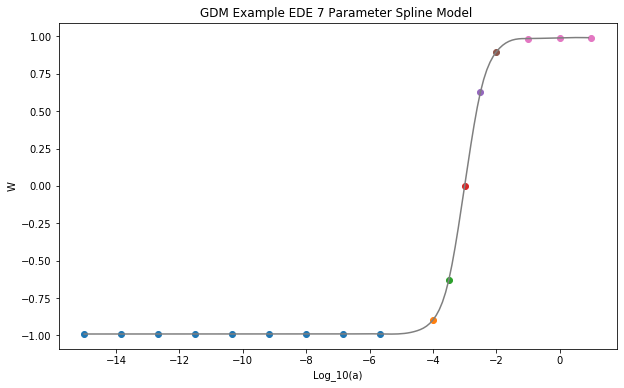

In [17]:
plt.figure(1,figsize=(10,6))
x_vals=np.arange(-15,1,1/10)
y_vals=interpolate.splev(x_vals,EDE.w_spline_rep)
plt.plot(EDE_log10a_vals[:9],EDE_w_vals[:9],'o',EDE_log10a_vals[10],EDE_w_vals[10],'o',EDE_log10a_vals[11],EDE_w_vals[11],'o',EDE_log10a_vals[12],EDE_w_vals[12],'o',EDE_log10a_vals[13],EDE_w_vals[13],'o',EDE_log10a_vals[14],EDE_w_vals[14],'o',EDE_log10a_vals[15:],EDE_w_vals[15:],'o',x_vals,y_vals)
plt.xlabel('Log_10(a)')
plt.ylabel('W')
plt.title('GDM Example EDE 7 Parameter Spline Model ')

In [18]:
EDE_log10a_vals[10]

-4.0

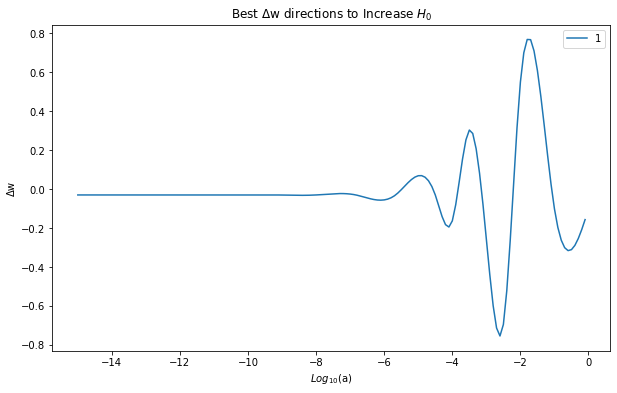

In [28]:
plt.figure(2,figsize=(10,6))
x_vals=np.arange(-15,0,1/10)
y_vals=interpolate.splev(x_vals,EDE.w_spline_rep)
prin_w_spline_vec=[None]*7
for i in range(1):
    prin_w_spline_vec[i]=interpolate.splrep(EDE_log10a_vals,principle_w[i], s=0)
    y_vals=interpolate.splev(x_vals,prin_w_spline_vec[i])
    plt.plot(x_vals,y_vals)

plt.xlabel('$Log_{10}$(a)')
plt.ylabel('Δw')
plt.title('Best Δw directions to Increase $H_0$')
plt.legend(np.arange(1,8))

Text(0.5, 1.0, 'Overall Shape of Best w to Increase $H_0$*')

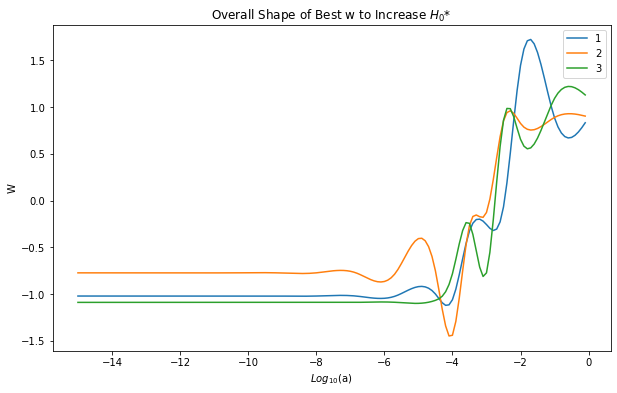

In [26]:
plt.figure(3,figsize=(10,6))
x_vals=np.arange(-15,0,1/10)
y0_vals=interpolate.splev(x_vals,EDE.w_spline_rep)
prin_w_spline_vec=[None]*7
for i in range(3):
    prin_w_spline_vec[i]=interpolate.splrep(EDE_log10a_vals,principle_w[i], s=0)
    y_vals=interpolate.splev(x_vals,prin_w_spline_vec[i])
    plt.plot(x_vals,y_vals+y0_vals)

    plt.legend(np.arange(1,8))
plt.xlabel('$Log_{10}$(a)')
plt.ylabel('W')
plt.title('Overall Shape of Best w to Increase $H_0$*')

In [17]:
dsg_dict={'dsg_log10a_vals':np.concatenate(([-15],np.arange(-4,-1.9,.5),[1])),
    'dsg_w_vals':np.zeros(len(np.concatenate(([-15],np.arange(-7,-2),[1])))),
    'dsg_alpha' : 0.00001200901405,
    'dsg_c_eff2':1/3.,
    'nap' : 'y',
    'dsg_c_vis2':1/3.}
dsg_test_params=classy_params(**{**dsg_dict,**{'h':0.67556}})
principle_w_directions(dsg_test_params,np.identity(7))

[array([ 0.12579747,  0.46067088, -0.25884386, -0.17781462,  0.74233594,
        -0.3492995 ,  0.01632095]),
 array([ 0.10398226,  0.55587729,  0.27601925, -0.03986227, -0.50704074,
        -0.50527417, -0.30003367]),
 array([ 0.48764173,  0.33146137, -0.472614  ,  0.49398303, -0.23049365,
         0.23462168,  0.27709388]),
 array([ 0.2183688 , -0.18766219, -0.56191578, -0.37277597, -0.14559037,
         0.09720087, -0.65707088]),
 array([-0.52622745,  0.38713348, -0.31264425, -0.47413634, -0.26578367,
         0.24542102,  0.34610433]),
 array([-0.35776654, -0.32479119, -0.46651505,  0.28712884, -0.14177476,
        -0.65218938,  0.14485664]),
 array([ 0.53195025, -0.27988818,  0.04813705, -0.5258931 , -0.16365242,
        -0.26946255,  0.51031227])]

In [18]:
fisher_cl_test=fisher_cl(**EDE_test_params.classy_dict)

In [19]:
dparam_names=['h']+['dsg_w_vals']*7+['T_cmb','N_ur','omega_b','omega_cdm']
step_size=10**-5
dparam_step=[step_size]+list(EDE_basis*step_size)+[step_size]*5


grad_raw_cl=multivar_der_of_raw_cl(EDE_test_params,dparam_names,dparam_step)


In [20]:
fisher_param_l=np.transpose(grad_raw_cl,(0,2,1))@fisher_cl_test@grad_raw_cl
fisher_param=np.sum(fisher_param_l,axis=0)

In [21]:
fisher_param

array([[ 2.00175904e-21, -1.86869262e-22, -4.06660315e-22,
        -1.00125243e-23, -5.10885001e-22, -6.33006619e-22,
        -1.03517221e-21, -5.13192140e-22,  4.13079287e-22,
         8.84077989e-23, -3.37836187e-20,  7.30531582e-21],
       [-1.86869262e-22,  2.23761492e-23,  3.62115431e-23,
         3.21973590e-24,  4.23360426e-23,  5.42925462e-23,
         9.44269698e-23,  4.87808993e-23, -4.59597104e-23,
        -1.54043602e-23,  3.31788305e-21, -6.70958307e-22],
       [-4.06660315e-22,  3.62115431e-23,  8.84188466e-23,
        -2.42687654e-24,  1.03984018e-22,  1.26565255e-22,
         2.15772909e-22,  1.08459945e-22, -8.59359818e-23,
        -1.62485550e-23,  7.15591408e-21, -1.49882526e-21],
       [-1.00125243e-23,  3.21973590e-24, -2.42687654e-24,
         3.95968964e-24,  1.51933710e-24,  4.04959687e-24,
         1.73067138e-25, -3.10078692e-25, -1.97514088e-24,
        -3.37950006e-24, -2.26203663e-23, -2.38021486e-23],
       [-5.10885001e-22,  4.23360426e-23,  1.0398401

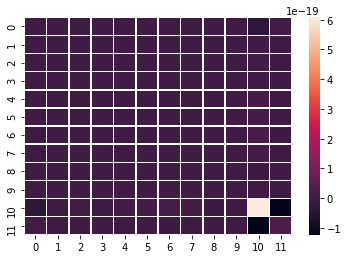

In [22]:
ax = sns.heatmap(fisher_param, linewidth=0.5)
plt.show()

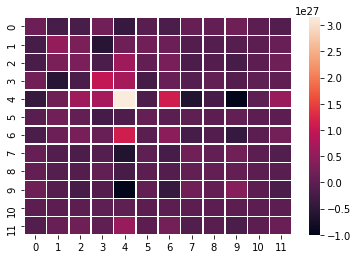

In [23]:
ax = sns.heatmap(np.linalg.inv(fisher_param), linewidth=0.5)
plt.show()

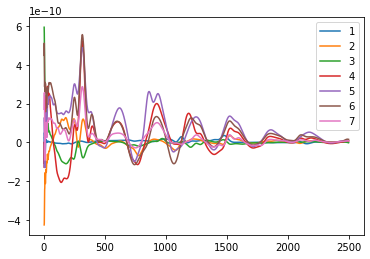

In [24]:
k_vals=np.arange(2,2501)
plt.figure(1)
for i in np.arange(1,8):
    plt.plot(k_vals,grad_raw_cl[:,0,i]*k_vals*(k_vals+1)/2/np.pi)

plt.legend(np.arange(1,8))


In [25]:
plt.figure(1)
for i in np.arange(1,8):
    plt.logplot(k_vals,grad_raw_cl[:,1,i]*k_vals*(k_vals+1)/2/np.pi)

plt.legend(np.arange(1,8))

AttributeError: module 'matplotlib.pyplot' has no attribute 'logplot'

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(1)
for i in np.arange(1,8):
    plt.semilogx(k_vals,grad_raw_cl[:,2,i]*k_vals*(k_vals+1)/2/np.pi)

plt.legend(np.arange(1,8))

In [ ]:
anchors=np.arange(-15,2)
EDE_vals = np.array([-0.999]*10+[-0.9,-0.3,0,0.3,0.9]+[0.999]*2)
w_spline_rep=interpolate.splrep(anchors,EDE_vals, s=0)
w_spline_rep

plt.figure(4)
plt.plot(np.arange(-15,2),interpolate.splev(np.arange(-15,2),w_spline_rep))

In [ ]:
k_vals=np.arange(2501)[2:]

In [ ]:
k_vals